# Setup 

In [1]:
import sys
assert sys.version_info >= (3,7)

In [3]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [4]:
import matplotlib.pyplot as plt

In [5]:
plt.rc('font', size = 14)
plt.rc('axes', labelsize = 14, titlesize = 14)
plt.rc('legend', fontsize = 14)
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)

# PCA

In [7]:
import numpy as np
from scipy.spatial.transform import Rotation

In [8]:
m = 60
X = np.zeros((m,3))
np.random.seed(42)
angles = (np.random.randn(m) ** 3 + 0.5)* 2 * np.pi
X[:, 0], X[: , 1] = np.cos(angles), np.sin(angles) * 0.5
X += 0.28 * np.random.randn(m, 3)
X = Rotation.from_rotvec([np.pi / 29, -np.pi/20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]

array([[-7.79425348e-02, -8.24738682e-01, -2.73899800e-01],
       [-9.35112071e-01, -8.20462926e-01,  3.40949325e-01],
       [ 4.22829302e-01, -8.58801212e-02,  3.12192365e-01],
       [ 5.67849563e-01,  6.30549520e-01,  7.75378163e-01],
       [-7.67493791e-01, -2.49319547e-01, -6.84489009e-01],
       [-3.71368835e-01, -4.74059350e-01, -1.83953445e-02],
       [-1.59363414e-01, -8.74231184e-01, -3.74076913e-02],
       [ 7.60542608e-01,  9.41524501e-01,  2.58317519e-01],
       [-6.52843251e-01, -6.36017538e-01,  2.73293742e-01],
       [ 2.80629806e-01, -7.32018778e-01,  2.38773178e-01],
       [-7.26687342e-01, -1.17633757e-01, -1.13144416e-01],
       [-5.16185115e-01, -4.28245745e-01, -3.57708147e-01],
       [-4.56338086e-01, -6.14338414e-01,  3.74146387e-02],
       [-2.56958299e-01, -9.91636134e-01, -1.23177290e-01],
       [-4.34588043e-01, -4.26441132e-01,  2.19195017e-02],
       [-7.26095081e-01,  4.53163878e-01,  2.26885301e-01],
       [-4.42827121e-01, -4.69768880e-01

## principal components

In [9]:
X_centered = X - X.mean(axis = 0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

In [10]:
m,n = X.shape
cov = np.zeros_like(X_centered)
cov[:n, :n] = np.diag(s)
assert np.allclose(X_centered, U @ cov @ Vt)

## projecting down to d dimensions

In [11]:
W2 = Vt[:2].T
X2D = X_centered @ W2

## PCA from scikit-learn

In [12]:
from sklearn.decomposition import PCA

In [13]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [14]:
pca.components_

array([[ 0.67487689,  0.70794452,  0.20822042],
       [-0.58336815,  0.68464219, -0.43697445]])

In [17]:
# explained_variable ratio

pca.explained_variance_ratio_

array([0.68734086, 0.18295512])

### choosing the right no. of dimensions

In [18]:
from sklearn.datasets import fetch_openml

In [21]:
mnist = fetch_openml('mnist_784', as_frame = False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]


In [22]:
# method 1
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum > 0.95) + 1

In [23]:
# or we can directly run PCA to retain desired variance
pca = PCA(n_components= 0.95)
X_red = pca.fit_transform(X_train)

In [24]:
pca.n_components_

154

In [25]:
pca.explained_variance_ratio_.sum()

0.9501960192613034

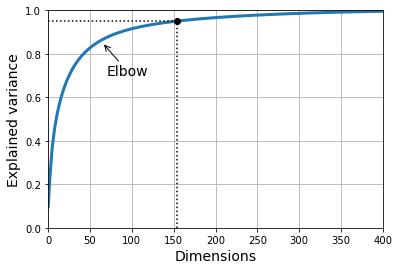

In [31]:
#alternatively we can plot explained variance as function of no. of dimensions

plt.figure(figsize = (6,4))
plt.plot(cumsum, linewidth = 3)
plt.axis([0, 400, 0, 1])
plt.xlabel('Dimensions')
plt.ylabel('Explained variance')
plt.plot([d,d], [0, 0.95], "k:")
plt.plot([0,d], [0.95,0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy = (65, 0.85) ,xytext = (70, 0.7), arrowprops = dict(arrowstyle="->"))
plt.grid(True)
plt.show()

In [32]:
# tuning PCA hyperparameters  along with training hyperparameters

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

In [37]:
clf = make_pipeline(PCA(random_state=42), RandomForestClassifier(random_state=42))
param_dis={
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50,500)
}
rnd_search = RandomizedSearchCV(clf, param_dis, n_iter = 10, cv = 3, random_state=42)

In [38]:
rnd_search.fit(X_train[:10000], y_train[:10000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       

In [39]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 475, 'pca__n_components': 57}


In [40]:
#decompression to original data
X_recovered = pca.inverse_transform(X_red)

In [44]:
# reconstruction error
((X_train - X_recovered)**2).sum() #does this make sense ...maybe not

10245013818.739277